In [1]:
#imports and functions
import pandas as pd
from datetime import date
def rate_per_period(i, n, p):
    """when compounding is different from payment period, need to calculate new rate for the period
    r_p = rate_per_period
    i = nominal annual interest rate
    n = number of compounding periods per year
    p = number of payment periods per year
    """
    r_p = ((1 + i/n)**(n/p)) - 1
    return r_p
def payment_amount_per_period(P, r, n):
    """payment amount per period, where r is the interest rate per period, and n is the total payments
    if doing for monthly payments, r = r_y/12, n = n_y*12
    A = payment Amount per period
    P = initial Principal (loan amount)
    r = interest rate per period
    n = total number of payments or periods"""
    A = P * (r*(1+r)**n) / (((1+r)**n)-1)
    return A

#regular amortization table and summary
def amortization_table(interest_rate=.0725, years=30, compounds_year=12, payments_year=12, principal=462000, start_date=date(2023,11,1)):
    #getting rate of interest per payment period
    period_rate = rate_per_period(i=interest_rate, n=compounds_year, p=payments_year)

    #using number of payments to get a range of payment dates, to be used as index for df
    if payments_year == 12: freq_var = 'MS'
    elif payments_year == 26: freq_var = '2W-WED'
    elif payments_year == 52: freq_var = 'W-WED'
    else: freq_var = None
    rng = pd.date_range(start_date, periods=years*payments_year, freq=freq_var)

    #setting up df
    df = pd.DataFrame(index=rng,
                      columns=['Payment_#', 'Total_Payment', 'Principal', 'Interest', 'Balance_In', 'Balance_Out'],
                      dtype='float')
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period" #not sure if you need this, or even the index += 1

    #filling in the Payment_# column and the first principal
    df['Payment_#'] = range(1, years * payments_year +1)
    df.loc[1, 'Balance_In'] = principal

    #filling in the payment per period column
    total_payment_per_period = payment_amount_per_period(P=principal, r=period_rate, n=years*payments_year)
    df['Total_Payment'] = total_payment_per_period

    #filling out the first row
    df.loc[1, 'Interest'] = period_rate * df.loc[1, 'Balance_In']
    df.loc[1, 'Principal'] = df.loc[1, 'Total_Payment'] - df.loc[1, 'Interest']
    df.loc[1, 'Balance_Out'] = df.loc[1, 'Balance_In'] - df.loc[1, 'Principal']
    new_balance = df.loc[1, 'Balance_Out']

    #loop to fill in the rest of the df table (starting with the second row)
    for index, row in df.iloc[1:].iterrows():
        df.loc[index, 'Balance_In'] = new_balance
        df.loc[index, 'Interest'] = period_rate * df.loc[index, 'Balance_In']
        df.loc[index, 'Principal'] = df.loc[index, 'Total_Payment'] - df.loc[index, 'Interest']
        df.loc[index, 'Balance_Out'] = df.loc[index, 'Balance_In'] - df.loc[index, 'Principal']
        new_balance = df.loc[index, 'Balance_Out']


    ##making summary stats (should this all happen outside the function?)

    #recording the pay schedule
    if payments_year == 12: pay_schedule = 'monthly'
    elif payments_year == 26: pay_schedule = 'biweekly'
    elif payments_year == 52: pay_schedule = 'weekly'
    else: pay_schedule = None

    #finding the payoff date and where the principal crosses the interest (do later, think they're the same)
    principal_overtakes = df[df['Principal'] > df['Interest']].iloc[0]['index']
    end_date = df.loc[df.last_valid_index()]['index']

    #putting together the summary row
    summary_ref = pd.DataFrame.from_dict(dict([('pay schedule', [pay_schedule]),
                                               ('start date', [start_date]),
                                               ('end date', [end_date]),
                                               ('principal', [principal]),
                                               ('yearly interest', [interest_rate]),
                                               ('term (yrs)', [years]),
                                               ('principal overtake', [principal_overtakes])]))
    payment_info = (df[["Total_Payment", "Principal", "Interest", ]].sum().to_frame().T)

    summary_stats = pd.concat([summary_ref, payment_info], axis=1)

    return df, summary_stats

amort_monthly, summary_monthly = amortization_table(payments_year=12)
amort_biweekly, summary_biweekly = amortization_table(payments_year=26)
amort_weekly, summary_weekly = amortization_table(payments_year=52)

summary_summary = pd.concat([summary_monthly, summary_biweekly, summary_weekly])

In [2]:
amort_monthly.head()

,index,Payment_#,Total_Payment,Principal,Interest,Balance_In,Balance_Out
Period,,,,,,,
1,2023-11-01,1,3151.654414,360.404414,2791.250000,462000.000000,461639.595586
2,2023-12-01,2,3151.654414,362.581857,2789.072557,461639.595586,461277.013729
3,2024-01-01,3,3151.654414,364.772456,2786.881958,461277.013729,460912.241273
4,2024-02-01,4,3151.654414,366.976290,2784.678124,460912.241273,460545.264984
5,2024-03-01,5,3151.654414,369.193438,2782.460976,460545.264984,460176.071546


In [3]:
print(summary_summary)

  pay schedule  start date   end date  principal  yearly interest  term (yrs)  \
0      monthly  2023-11-01 2053-10-01     462000           0.0725          30   
0     biweekly  2023-11-01 2053-09-10     462000           0.0725          30   
0       weekly  2023-11-01 2053-09-17     462000           0.0725          30   

  principal overtake  Total_Payment  Principal       Interest  
0         2044-04-01   1.134596e+06   462000.0  672595.588989  
0         2044-03-09   1.132756e+06   462000.0  670755.749072  
0         2044-03-09   1.131968e+06   462000.0  669968.463610  


C:\Users\alexr\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


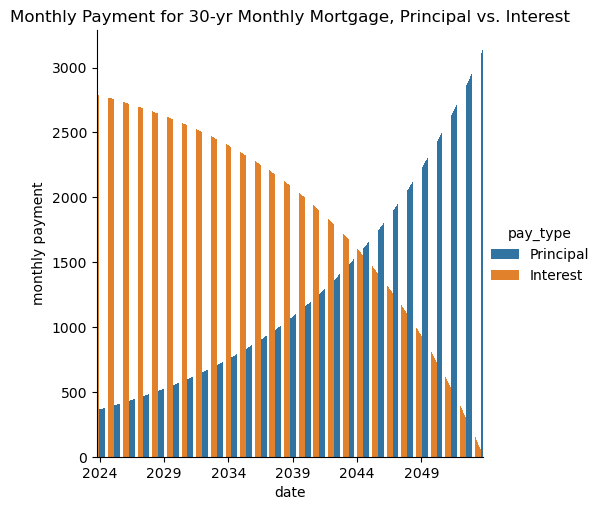

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

amorting = amort_monthly.reset_index().rename(columns={'index':'date'})

amort_melt = amorting[['date','Principal','Interest']].melt(id_vars="date",var_name="pay_type",value_name="pay_amount")

g = sns.catplot(x='date', y='pay_amount', hue='pay_type', data=amort_melt, kind='bar')
g.set(xlabel= 'date', ylabel='monthly payment', title='Monthly Payment for 30-yr Monthly Mortgage, Principal vs. Interest',
      xticks = range(2,360, 60), xticklabels=['2024', '2029', '2034', '2039', '2044', '2049'])

In [5]:
#what happens if i type like this

In [6]:
"""what happens if i type like this"""

'what happens if i type like this'

In [7]:
""how about this?""

SyntaxError: invalid syntax (2698570128.py, line 1)